In [2]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)
api_key=os.environ.get("openrouter_api_key")

In [3]:
from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(
#     model = "qwen/qwen3-30b-a3b:free", # "qwen/qwen3-14b:free", "qwen/qwen3-30b-a3b:free",
#     base_url="https://openrouter.ai/api/v1",
#     api_key=api_key,
#     )

from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0,max_tokens=3000,) # "gemma2-9b-it", qwen-qwq-32b
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001B84EED63C0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001B84EED7470>, model_name='llama-3.3-70b-versatile', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'), max_tokens=3000)

In [ ]:
from typing import Union, List
from langchain_ollama import OllamaEmbeddings
from langchain_elasticsearch import ElasticsearchStore, DenseVectorStrategy

def load_elastic_vectorstore(index_names: Union[str, List[str]]):
    # 단일 문자열인 경우 리스트로 변환
    if isinstance(index_names, str):
        index_names = [index_names]
    
    vector_store = ElasticsearchStore(
        index_name=index_names, 
        embedding=OllamaEmbeddings(
            base_url="http://localhost:11434", 
            model="bge-m3:latest"
        ), 
        es_url="http://localhost:9200",
        es_user="Kstyle",
        es_password="12345",
    )
    return vector_store


index_names = ["ship_safety"]
vector_store = load_elastic_vectorstore(index_names=index_names)
vector_store

In [5]:
from FlagEmbedding import FlagReranker
reranking_model_path = "D:/LLMs/bge-reranker-v2-m3"
reranker = FlagReranker(model_name_or_path=reranking_model_path, 
                        use_fp16=True,
                        batch_size=512,
                        max_length=2048,
                        normalize=True)
reranker

d:\AI_PROJECT\quick_test\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import heapq

def reranking(query: str, docs: list, min_score: float = 0.5, top_k: int = 3):
    """
    doc string
    """
    global reranker
    inputs = [[query, doc.page_content.lower()] for doc in docs]
    scores = reranker.compute_score(inputs)
    if not isinstance(scores, list):
        scores = [scores]

    print(f"---- original scores: {scores}")

    # Filter scores by threshold and keep index
    filtered_scores = [(score, idx) for idx, score in enumerate(scores) if score >= min_score]

    # Get top_k using heapq (more efficient than sorting full list)
    top_scores = heapq.nlargest(top_k, filtered_scores, key=lambda x: x[0])

    # Get document objects from top indices
    reranked_docs = [docs[idx] for _, idx in top_scores]

    return top_scores, reranked_docs


In [ ]:
import operator
import operator
from typing import Annotated
from typing import Dict, TypedDict
from langgraph.graph.message import add_messages
class OverAllState(TypedDict):
    """
    Represents the overall state of our graph.
    """
    questions: Annotated[list, operator.add]
    context: Annotated[list, operator.add]
    rerank_context: Annotated[list, operator.add]
    top_scores: Annotated[list, operator.add]
    generations: Annotated[list, operator.add]

In [118]:
from langchain_tavily import TavilySearch
from langchain.schema import Document

def web_agent(state: OverAllState):
    
    """ Retrieve docs from web search """
    question = state['questions'][-1]

    # Search
    print("---Web Search---")
    tavily_search = TavilySearch(max_results=3)
    search_docs = tavily_search.invoke(question)
    contents = [f"{d['title']} \n {d['content']}" for d in search_docs['results']]
    metas = [d['url'] for d in search_docs['results']]

    documents = []
    for content, url in zip(contents, metas):
        documents.append(Document(page_content=content, metadata={'url':url}))
    print(f"---- Web Search 문서개수: {len(documents)}")
    return {"context": [documents]} 

In [119]:
def retrieve_agent(state: OverAllState):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, 
        that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state['questions'][-1]
    retriever = vector_store.as_retriever(
        search_type="mmr", 
        search_kwargs={"fetch_k": 10, "k":5},
        )
    documents = retriever.invoke(question)
    print(f"---- Retrieve 문서개수: {len(documents)}")

    return {"context": [documents]}

In [120]:
def reranking_agent(state:OverAllState):
    """Rerank retrieved documents"""
    print("---RERANK---")
    question = state['questions'][-1]

    ## 1차 검색 문서 Flattend : [[문석검색], [웹검색]] --> [문서검색, 웹검색]
    flattened_context = [item for sublist in state["context"][-2:] for item in sublist]
    print(f"--- flattened_context: {len(flattened_context)}")
    
    top_scores, documents = reranking(query=question, docs=flattened_context, min_score = 0.5, top_k= 3)
    print(f"---- Retrieve Reranking 문서개수: {len(documents)} / top_scores: {top_scores}")
    return {'rerank_context': [documents], 'top_scores': [top_scores]}

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

## 현재 안전관리자 관점에서 작성됨..
system_prompt = """You are a Smart Safety Manager in Shipyard. 
Use the following pieces of retrieved contexts or web search results to review and generate safety report.
The final purpose of your report is to improve the safety level and lower any accident risks in the shipyard.
Think step by step and generate logical and reasonable safety report in Korean Language.
Nonetheless, If you don't know the answer, just say that you don't know. 
Question: {question} 
Context: {context} 
Answer:"""

def generate_agent(state: OverAllState):
    print("---GENERATE---")

    question = state['questions'][-1]
    context = state['rerank_context'][-1]
    print(f"---- 최종 컨텍스트 개수 재확인: {len(context)}")

    prompt = ChatPromptTemplate.from_messages([("human", system_prompt),])
    rag_chain = prompt | llm | StrOutputParser()

    #Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    # Static the Response
    generation = rag_chain.invoke({"context": format_docs(context), 
                                   "question": question})
    return {"generations": [generation]}

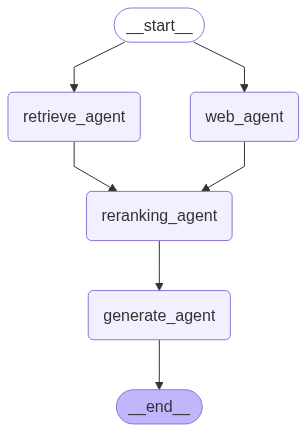

In [128]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
def rag_builder(state):
    rag_builder = StateGraph(state)
    rag_builder.add_node("web_agent", web_agent)
    rag_builder.add_node("retrieve_agent", retrieve_agent)
    rag_builder.add_node("reranking_agent", reranking_agent)
    rag_builder.add_node("generate_agent", generate_agent)

    rag_builder.add_edge(START, "web_agent")
    rag_builder.add_edge("web_agent", "reranking_agent")
    rag_builder.add_edge(START, "retrieve_agent") 
    rag_builder.add_edge("retrieve_agent", "reranking_agent")
    rag_builder.add_edge("reranking_agent", "generate_agent") 
    rag_builder.add_edge("generate_agent", END)

    memory = MemorySaver()
    graph = rag_builder.compile(checkpointer=memory)

    return graph

app = rag_builder(OverAllState)
app

In [129]:
# Run
from IPython.display import Markdown
import uuid 
import pprint
inputs = {"questions": ["중대재해의 정의 및 요건"]}
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
for output in app.stream(inputs, config=config, stream_mode="updates", debug=False):
    # print(output)
    for key, value in output.items():
        # Node
        print(f">>> Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

pprint.pprint(value['generations'][-1])

---RETRIEVE---
---Web Search---
---- Retrieve 문서개수: 5
---- Web Search 문서개수: 3
>>> Node 'retrieve_agent':
'\n---\n'
>>> Node 'web_agent':
'\n---\n'
---RERANK---
--- flattened_context: 8
>>> original scores: [0.864710137893859, 0.2235518598367174, 0.004967349823553644, 0.025638358316331378, 0.2536298336734885, 0.9583971676126322, 0.9737460157848937, 0.8163613816617807]
---- Retrieve Reranking 문서개수: 3 / top_scores: [(0.9737460157848937, 6), (0.9583971676126322, 5), (0.864710137893859, 0)]
>>> Node 'reranking_agent':
'\n---\n'
---GENERATE---
---- 최종 컨텍스트 개수 재확인인: 3
>>> Node 'generate_agent':
'\n---\n'
('중대재해의 정의 및 요건에 대한 안전 보고서\n'
 '\n'
 '중대재해는 근로자의 생명과 안전에 큰 영향을 미치는 사고로, 사업주는 즉각적인 대응 및 보고 의무를 가진다. 「산업안전보건법」에 따르면, '
 '중대재해 발생 시 신속한 신고, 초동조치, 원인조사 등이 필요하다.\n'
 '\n'
 '중대재해의 정의는 다음과 같다.\n'
 '\n'
 '* 사망자가 1명 이상 발생한 재해\n'
 '* 3개월 이상의 요양이 필요한 부상자가 동시에 2명 이상 발생한 재해\n'
 '* 부상자 또는 직업성 질병자가 동시에 10명 이상 발생한 재해\n'
 '\n'
 '중대재해의 요건은 다음과 같다.\n'
 '\n'
 '* 재해예방에 필요한 인력 및 예산 등 안전보건관리체계의 구축 및 그 이행에 관한 조치\n'


In [124]:
cur_state = app.get_state(config=config)
cur_state.values

{'questions': ['중대재해의 정의 및 요건'],
 'context': [[Document(metadata={'filename': '안전보건 실무길잡이_선박건조 및 수리업.pdf', 'page': '32'}, page_content='This page explains 안전보건 실무길잡이_선박건조 및 수리업 that belongs to 안전 and  가이드 categories.\n<!-- image -->\n\n## Check Box\n\n## 용어의 정의\n\n- 사업주는 산업재해 조사표에 근로자 대표의 확인올 받아야 하여, 그 기재 내용에 대하여\n- 산업재해가 발생한 경우 다음 사항울 기록하고 3년간 보존한다.\n- 사업장의 개요 및 근로자의 인적사항, 재해 발생의 일시 및 장소 재해 발생의 원인 및 과정, 재해 재발방지 계획\n- 하는 경우 갈음활 수있음\n\n## 중대재해\n\n0 사망자가 1명 이상 발생한 재해   0 3개월 이상의 요양이 필요한 부상자가 동시에 2명 이상 발생한 재해 부상자 또는 직업성 질병자가 동시에 10명 이상 발생한 재해름 말한다.\n\n## 지체없이\n\n정당한 사유재해 등으로 인한 통신수단의 이용이 곤란하거나 재해자 응급구호; 2차 재해 재발방지루 위한 조치\n\n## 3일 이상의 휴업\n\n(휴업일수에 사고 발생일은 포함되지 않으나 법정공휴일 또는 근로 제공 의무가 없는 휴무일은 포함)\n\n## 작업중지 요건\n\n0 고용노동부장관은 . (중락).. 해당 사업장에 산재가 다시 발생할 급박한 위험이 있다고 판단 되는 경우 그 작업의 중지름 명할 수 있음\n\n- 중대재해가 발생한 해당 직업 중대재해가 발생한 작업과 동일한 작업\n\n0고용노동부장관은 토사 구축물의봉과 화재 폭발 유해하거나 위험한 물질의 누출 등으로 인해 중대재해가 발생해 . (중락). 확산월 수 있다고 판단되는 등 불가피한 경우 해당사업장의\n\n<!-- image -->'),
   Document(metadata={'filename': '중대재해

In [125]:
# Run
from IPython.display import Markdown
import uuid 
import pprint
inputs = {"questions": ["중대재해 처벌 사례"]}
# config = {"configurable": {"thread_id": str(uuid.uuid4())}}
for output in app.stream(inputs, config=config, stream_mode="updates", debug=False):
    # print(output)
    for key, value in output.items():
        # Node
        print(f">>> Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

pprint.pprint(value['generations'][-1])

---RETRIEVE---
---Web Search---
---- Retrieve 문서개수: 5
---- Web Search 문서개수: 3
>>> Node 'retrieve_agent':
'\n---\n'
>>> Node 'web_agent':
'\n---\n'
---RERANK---
--- flattened_context: 8
>>> original scores: [0.6250951042350936, 0.1543987424424548, 0.8436195161439453, 0.7154628506440146, 0.7955847495662411, 0.9963191660347478, 0.9857406373690819, 0.9379605198371225]
---- Retrieve Reranking 문서개수: 3 / top_scores: [(0.9963191660347478, 5), (0.9857406373690819, 6), (0.9379605198371225, 7)]
>>> Node 'reranking_agent':
'\n---\n'
---GENERATE---
---- 최종 컨텍스트 개수: 3
>>> Node 'generate_agent':
'\n---\n'
('중대재해 처벌 사례에 대한 안전 보고서\n'
 '\n'
 '중대재해처벌법은 사업장에서 중대한 인명 피해가 발생했을 때, 사업주나 경영책임자에게 형사책임을 묻는 법률입니다. 본 보고서는 '
 '중대재해처벌법 위반 사례를 분석하여 안전 수준을 향상시키고 사고 위험을 낮추기 위한 목적으로 작성되었습니다.\n'
 '\n'
 '1. 건설업 중대재해처벌법 위반 사례\n'
 '건설업에서 중대재해처벌법 위반 사례는 다음과 같습니다.\n'
 '- 건설 현장에서 안전 관리 소홀로 인한 사고\n'
 '- 안전 규정 위반으로 인한 사고\n'
 '- 근로자 교육 및 훈련 부족으로 인한 사고\n'
 '\n'
 '2. 제조업 중대재해처벌법 위반 사례\n'
 '제조업에서 중대재해처벌법 위반 사례는 다음과 같습니다.\n'
 '- 안전 장

In [126]:
cur_state = app.get_state(config=config)
cur_state.values

{'questions': ['중대재해의 정의 및 요건', '중대재해 처벌 사례'],
 'context': [[Document(metadata={'filename': '안전보건 실무길잡이_선박건조 및 수리업.pdf', 'page': '32'}, page_content='This page explains 안전보건 실무길잡이_선박건조 및 수리업 that belongs to 안전 and  가이드 categories.\n<!-- image -->\n\n## Check Box\n\n## 용어의 정의\n\n- 사업주는 산업재해 조사표에 근로자 대표의 확인올 받아야 하여, 그 기재 내용에 대하여\n- 산업재해가 발생한 경우 다음 사항울 기록하고 3년간 보존한다.\n- 사업장의 개요 및 근로자의 인적사항, 재해 발생의 일시 및 장소 재해 발생의 원인 및 과정, 재해 재발방지 계획\n- 하는 경우 갈음활 수있음\n\n## 중대재해\n\n0 사망자가 1명 이상 발생한 재해   0 3개월 이상의 요양이 필요한 부상자가 동시에 2명 이상 발생한 재해 부상자 또는 직업성 질병자가 동시에 10명 이상 발생한 재해름 말한다.\n\n## 지체없이\n\n정당한 사유재해 등으로 인한 통신수단의 이용이 곤란하거나 재해자 응급구호; 2차 재해 재발방지루 위한 조치\n\n## 3일 이상의 휴업\n\n(휴업일수에 사고 발생일은 포함되지 않으나 법정공휴일 또는 근로 제공 의무가 없는 휴무일은 포함)\n\n## 작업중지 요건\n\n0 고용노동부장관은 . (중락).. 해당 사업장에 산재가 다시 발생할 급박한 위험이 있다고 판단 되는 경우 그 작업의 중지름 명할 수 있음\n\n- 중대재해가 발생한 해당 직업 중대재해가 발생한 작업과 동일한 작업\n\n0고용노동부장관은 토사 구축물의봉과 화재 폭발 유해하거나 위험한 물질의 누출 등으로 인해 중대재해가 발생해 . (중락). 확산월 수 있다고 판단되는 등 불가피한 경우 해당사업장의\n\n<!-- image -->'),
   Document(metadata={'fi